In [1]:
import pyspark
from pyspark import SparkConf, SparkContext
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark.sql import functions as F
from pyspark.sql.types import StructType, StructField, IntegerType, StringType, FloatType, BooleanType, DoubleType
from pyspark.sql.functions import udf
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import MinMaxScaler

In [2]:
from tsfresh.convenience.bindings import spark_feature_extraction_on_chunk
from tsfresh.feature_extraction.settings import MinimalFCParameters

In [3]:
import string
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from tslearn.metrics import cdist_normalized_cc
from sklearn import metrics
from numpy import argmax
import itertools
import random

In [4]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.mllib.util import MLUtils
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.mllib.evaluation import BinaryClassificationMetrics

In [5]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .master('local[18]') \
    .config("spark.driver.memory", "15g") \
    .config("spark.sql.repl.eagerEval.enabled", True) \
    .getOrCreate()

### Load Train/test set

In [6]:
schema = StructType([
    StructField("bigram", StringType(), True),
    StructField("year", IntegerType(), True),
    StructField("bigram_percent", DoubleType(), True),
    StructField("medianA", DoubleType(), True),
    StructField("ntileA", IntegerType(), True),
    StructField("medianB", DoubleType(), True),
    StructField("ntileB", IntegerType(), True),
    StructField("label", IntegerType(), True),
    StructField("start_of_mainstreaming", IntegerType(), True),
    StructField("end_of_mainstreaming", IntegerType(), True),
    StructField("peak_year", IntegerType(), True),
    StructField('random_year', DoubleType(), True)])

In [7]:
# load full dataset
df = spark.read.option('header', False).schema(schema)\
                    .csv('/data/shared1/cleandata/traintest_set_newer')

In [7]:
# load sample
df = spark.read.option('header', False).schema(schema)\
                     .csv('/data/shared1/cleandata/traintest_sample_5percent')

### Filter years

In [8]:
def filter_years_mainstreaming(df, yearlag, yearsBeforeBreak):
    
    # df: dataframe
    # yearlag: the number of years we look at
    # traintest: True if traintest set, false if classify set
    # This function makes the years we use to the train and test set / and the classify set
    
    df = df.where((((col('label') == 1)) # mainstream
                   & (col('year') <= col('start_of_mainstreaming')-yearsBeforeBreak) # takes the years before the peak
                   & (col('year') > (col('start_of_mainstreaming')-yearlag-yearsBeforeBreak)) # want the timeserie to be yearlag long
                   & (col('start_of_mainstreaming') >= (1900+yearlag+yearsBeforeBreak)))  # want that we look at minimum "yearlag" years
                   | ((col('label') == 0) # not mainstream
                   & (col('year') < col('random_year'))
                   & (col('year') >= col('random_year') - yearlag)))

    df = df.orderBy(col("bigram").asc(),col("year").asc())
    return df

In [9]:
# Different number of years before peak

traintest_df = filter_years_mainstreaming(df, 30, 0)

In [11]:
test = traintest_df.groupBy('bigram').agg(count('*').alias('yearscount'))

### Extract features 

In [10]:
# All features
fc_parameters = {
    "absolute_sum_of_changes": None,
    "count_above": [{"t": 5e-6}],
    "count_above_mean": None,
    "count_below_mean": None,
    "longest_strike_above_mean": None,
    "longest_strike_below_mean": None,
    "maximum": None,
    "mean": None,
    "median": None,
    "minimum": None,
    "number_peaks": [{"n": 2}, {"n": 3}, {"n": 4}],
    "standard_deviation": None,
    "variance": None,
}

In [15]:
# selected features
fc_parameters = {
    "absolute_sum_of_changes": None,
    "count_above": [{"t": 5e-6}],
    "count_above_mean": None,
    "count_below_mean": None,
    "longest_strike_above_mean": None,
    "longest_strike_below_mean": None,
    "maximum": None,
    "mean": None,
    "minimum": None,
    "number_peaks": [{"n": 2}, {"n": 3}, {"n": 4}],
    "variance": None,
}

In [11]:
# all features
feature_arr = ["x__absolute_sum_of_changes", "x__count_above__t_5e-06",
               "x__count_above_mean", "x__count_below_mean", 
               "x__longest_strike_above_mean", "x__longest_strike_below_mean", "x__maximum",
               "x__mean", "x__median", "x__minimum", "x__number_peaks__n_2", 
               "x__number_peaks__n_3", "x__number_peaks__n_4", 
               "x__standard_deviation", "x__variance"]

In [17]:
# selected features
feature_arr = ["x__absolute_sum_of_changes", "x__count_above__t_5e-06",
               "x__count_above_mean", "x__count_below_mean", 
               "x__longest_strike_above_mean", "x__longest_strike_below_mean", "x__maximum",
               "x__mean", "x__minimum", "x__number_peaks__n_2", 
               "x__number_peaks__n_3", "x__number_peaks__n_4", "x__variance"]

In [12]:
def extract_features(traintest_df, fc_parameters):
    traintest_feature_extract = traintest_df.withColumn('kind', lit("x"))
    
    bigram_ids = traintest_feature_extract.select('bigram', 'label').distinct()\
             .withColumn("id", F.dense_rank().over(Window.orderBy(traintest_feature_extract.bigram)))
    
    traintest_feature_extract = traintest_feature_extract.join(bigram_ids.select('id', 'bigram'), 
                                                           ['bigram'], how='left')
    
    df_grouped = traintest_feature_extract.groupBy('id', 'kind')
    
    
    features = spark_feature_extraction_on_chunk(df_grouped, column_id="id", column_kind="kind",
                                             column_sort="year", column_value="bigram_percent",
                                             default_fc_parameters=fc_parameters)
    
    features = features.groupby("id").pivot("variable").sum("value")
    
    return bigram_ids, features

In [13]:
bigram_ids, features = extract_features(traintest_df, fc_parameters)

traintest_df = bigram_ids.join(features, ['id'], how='right')
traintest_df = traintest_df.drop('id')

/home2/s154326/.conda/envs/Thesis/lib/python3.8/site-packages/pyspark/sql/pandas/group_ops.py:73: UserWarning: It is preferred to use 'applyInPandas' over this API. This API will be deprecated in the future releases. See SPARK-28264 for more details.
  warnings.warn(


In [14]:
# Min-max feature scaling (normalization)
def minmax_data(df, columns):
    
    # Find the Max and the Min for each column
    aggMax = []
    aggMin = []
    for column in columns:
        aggMax.append(max(df[column]).alias(column))
        aggMin.append(min(df[column]).alias(column))
        
    Max = df.agg(*aggMax).collect()[0]
    Min = df.agg(*aggMin).collect()[0]
    
    
    # Normalize each dataframe, column by column
    for column in columns:            
        df = df.withColumn(column, ((df[column] - Min[column]) / (Max[column] - Min[column])))       
    
    return df, Max, Min

In [15]:
traintest_minmax, Max, Min = minmax_data(traintest_df, feature_arr)

In [16]:
traintest_minmax = traintest_minmax.dropna()

### Make train and test dataframe 

In [17]:
# split into train and test
train, test = traintest_minmax.randomSplit([0.7, 0.3], seed=4)

### Balance

In [19]:
# New method for balancing dataset, doesn't undersample so we keep all our data
def balanceDataset(df):

    numZeros = df.where(col('label') == 0).count()
    datasetSize = df.count()
    balancingRatio = (datasetSize - numZeros) / datasetSize

    weighted_df = df.withColumn('classWeightCol', when(df.label == 0, balancingRatio)\
                                                 .when(df.label == 1, 1.0 - balancingRatio))
    return weighted_df

In [20]:
# balance training data
train_balanced = balanceDataset(train)

### Correlation plot

In [21]:
numeric_data = train_balanced.toPandas()

In [22]:
result = pd.DataFrame()
result['label'] = numeric_data.iloc[:,1] 
numeric_data = numeric_data.drop(['label', 'classWeightCol'], axis=1)

In [23]:
corr = numeric_data.corr().to_numpy()

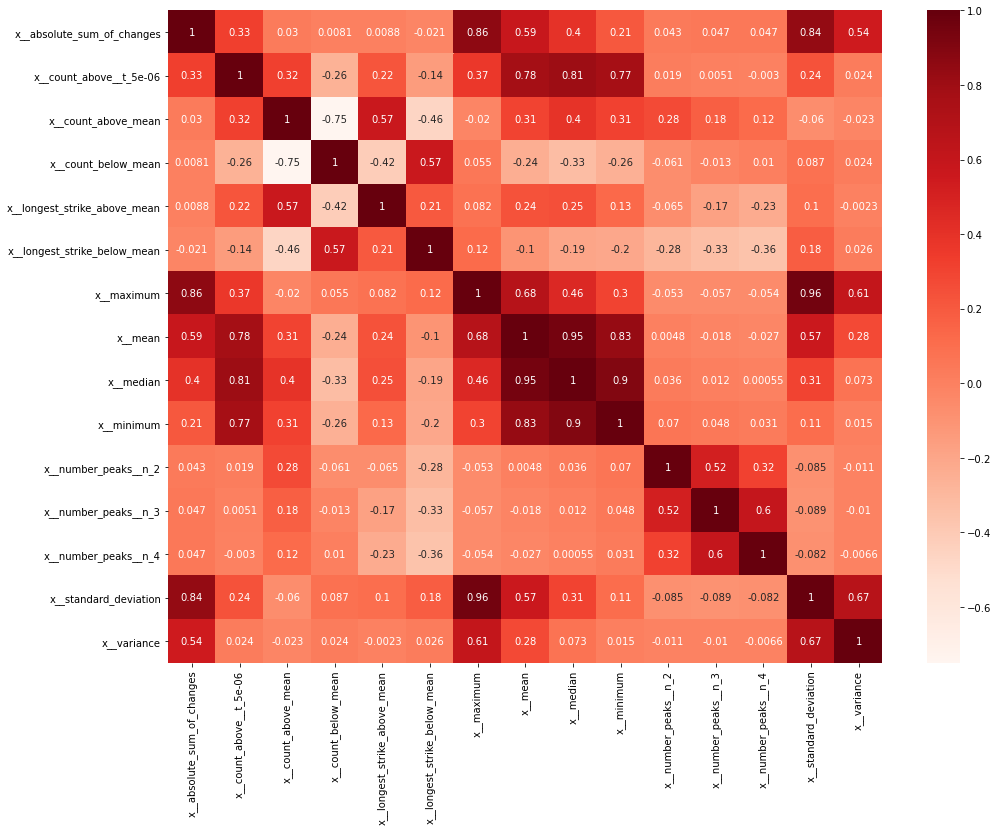

In [39]:
plt.figure(figsize=(16,12))
g = sns.heatmap(corr, annot=True, cmap=plt.cm.Reds)
g.set_yticklabels(feature_arr, rotation=0)
g.set_xticklabels(feature_arr, rotation=90)
plt.savefig('Feature_correlation_final',bbox_inches='tight')
plt.show()

#### distribution plots for features

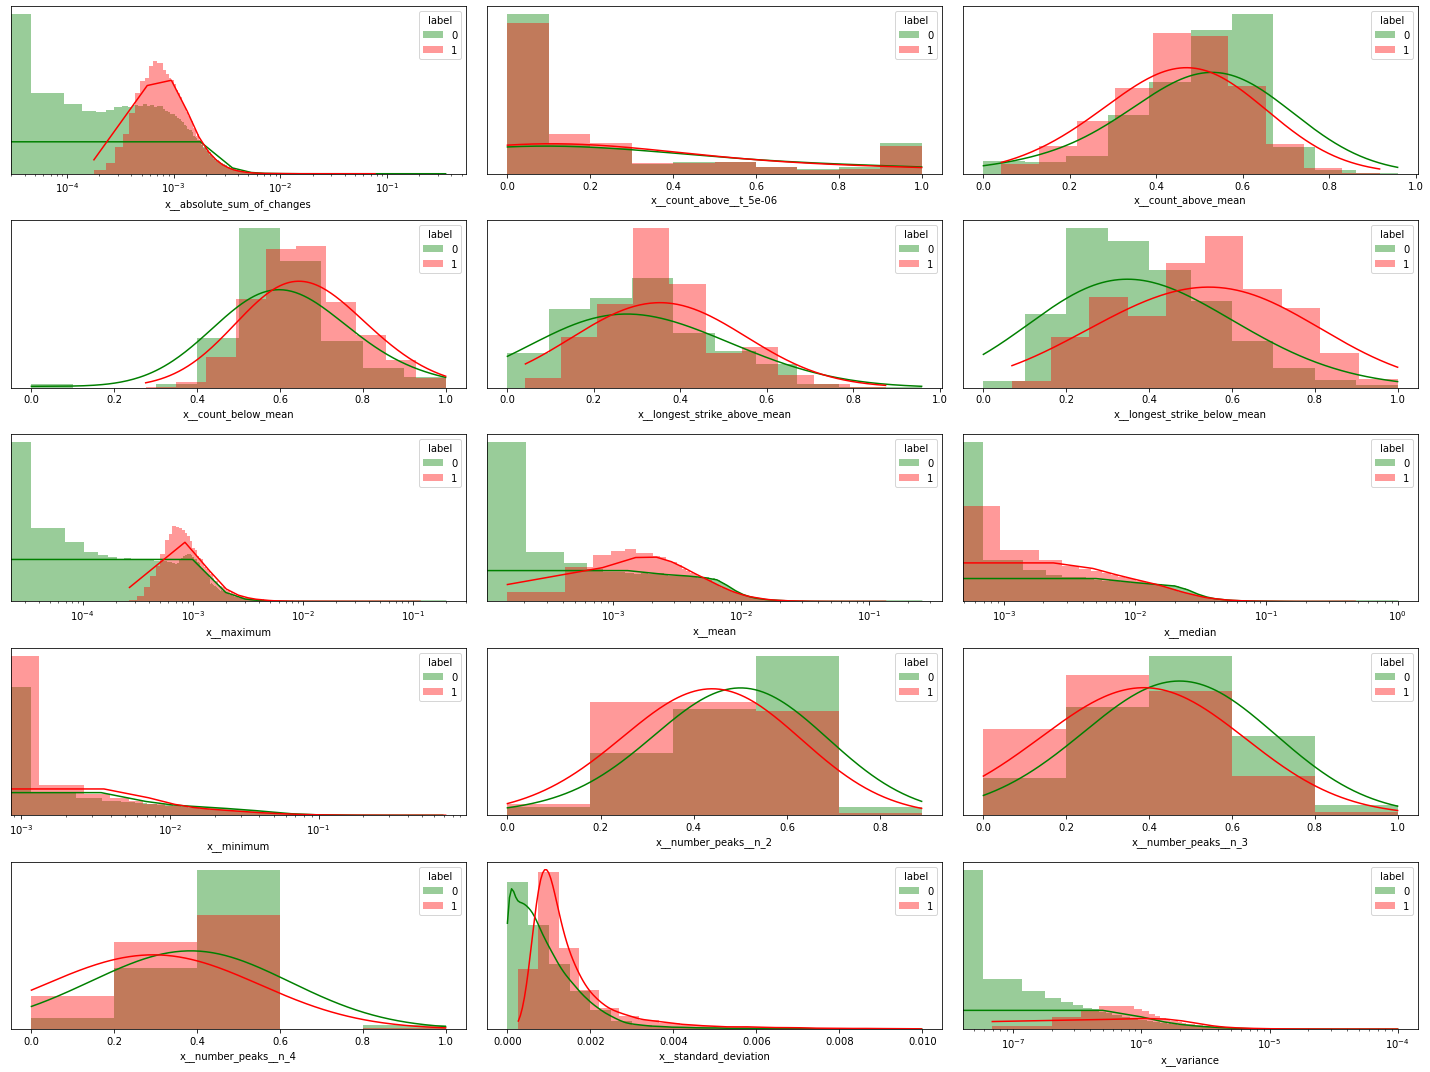

In [50]:
fig = plt.figure(figsize = (20, 15))
j = 0
for i in feature_arr:
    plt.subplot(5, 3, j+1)
    if ((j == 1) | (j == 2) | (j == 3) | (j == 4) | (j == 5)) :
        g = sns.histplot(numeric_data[i][result['label']==0], color='g', label = '0', 
                 stat='density', bins=10, kde=True, kde_kws={'bw_method':1}, edgecolor='none', alpha=0.4)
        g = sns.histplot(numeric_data[i][result['label']==1], color='r', label = '1', 
                 stat='density', bins=10, kde=True, kde_kws={'bw_method':1}, edgecolor='none', alpha=0.4)
        g.axes.get_yaxis().set_visible(False)
    if ((j == 0) |  (j == 6) | (j == 7) | (j == 8) | (j == 9)):
        g = sns.histplot(numeric_data[numeric_data[i] <= 1][i][result['label']==0], color='g', label = '0', 
                 stat='density', kde=True,  edgecolor='none', alpha=0.4)
        g = sns.histplot(numeric_data[numeric_data[i] <= 1][i][result['label']==1], color='r', label = '1', 
                 stat='density', kde=True,  edgecolor='none', alpha=0.4)
        g.set_xscale('log')
        g.axes.get_yaxis().set_visible(False)
    if ((j == 10) | (j == 11) | (j == 12)):
        g = sns.histplot(numeric_data[i][result['label']==0], color='g', label = '0', 
                 stat='density', bins=5, kde=True, kde_kws={'bw_method':1}, edgecolor='none', alpha=0.4)
        g = sns.histplot(numeric_data[i][result['label']==1], color='r', label = '1', 
                 stat='density', bins=5, kde=True, kde_kws={'bw_method':1}, edgecolor='none', alpha=0.4)
        g.axes.get_yaxis().set_visible(False)
    if (j == 13):
        g = sns.histplot(numeric_data[numeric_data[i] <= 1e-2][i][result['label']==0], color='g', label = '0', 
                 stat='density', bins=20, kde=True,  edgecolor='none', alpha=0.4)
        g = sns.histplot(numeric_data[numeric_data[i] <= 1e-2][i][result['label']==1], color='r', label = '1', 
                 stat='density', bins=20, kde=True,  edgecolor='none', alpha=0.4)
        g.axes.get_yaxis().set_visible(False)
    if (j == 14):
        g = sns.histplot(numeric_data[numeric_data[i] <= 0.0001][i][result['label']==0], color='g', label = '0', 
                 stat='density', kde=True,  edgecolor='none', alpha=0.4)
        g = sns.histplot(numeric_data[numeric_data[i] <= 0.0001][i][result['label']==1], color='r', label = '1', 
                 stat='density', kde=True,  edgecolor='none', alpha=0.4)
        g.set_xscale('log')
        g.axes.get_yaxis().set_visible(False)
    j += 1

    plt.legend(title='label', loc='best')
fig.tight_layout()
plt.savefig('feature_distributions_final',bbox_inches='tight')
plt.show()

### Train and test model

In [25]:
# selected features
selected_features = ["x__absolute_sum_of_changes", "x__count_above__t_5e-06",
               "x__count_above_mean", "x__count_below_mean", 
               "x__longest_strike_above_mean", "x__longest_strike_below_mean", "x__maximum",
               "x__mean", "x__minimum", "x__number_peaks__n_2", 
               "x__number_peaks__n_3", "x__number_peaks__n_4", "x__variance"]

In [25]:
# put all selected features in a vector
assembler = VectorAssembler(
    inputCols=selected_features,
    outputCol="features")

train = assembler.transform(train_balanced)
train = train.select('bigram', 'label', 'features', 'classWeightCol')

test = assembler.transform(test)
test = test.select('bigram', 'label', 'features')

In [26]:
# use weightCol to ensure model balances data
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label' , weightCol = 'classWeightCol', 
                            numTrees = 125, maxDepth = 15, seed = 4).setThresholds([1 - 0.457799, 0.457799])
rfModel = rf.fit(train)

In [27]:
# binary predictions
predictions = rfModel.transform(test)
evaluator = BinaryClassificationEvaluator()
evaluator.evaluate(predictions)

0.8163768639327488

In [28]:
# save Random Forrest model
rfModel.save("/data/shared1/cleandata/rf_model_optimal_thresholds.model")

### Cross validation

In [26]:
depths = range(5, 30, 2)
trees = range(10, 200, 12)

In [27]:
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label' , weightCol = 'classWeightCol')

In [28]:
# Create ParamGrid for Cross Validation
rfparamGrid = (ParamGridBuilder()
               .addGrid(rf.maxDepth, list(depths))
               .addGrid(rf.numTrees, list(trees))
             .build())

# Create 3-fold CrossValidator
rfcv = CrossValidator(estimator = rf,
                      estimatorParamMaps = rfparamGrid,
                      evaluator = BinaryClassificationEvaluator(),
                      numFolds = 3,
                      collectSubModels = True)

In [29]:
rfcvModel = rfcv.fit(train)

In [30]:
# save best model
rfbest = rfcvModel.bestModel

In [31]:
rfbest.getMaxDepth()

25

In [32]:
rfbest.getNumTrees

178

In [33]:
rfbest.save("/data/shared1/cleandata/rf_bestmodel_final.model")

In [35]:
# Save AUC from models
evaluator = BinaryClassificationEvaluator()

maxDepths = []
numTrees = []
AUCs = []

for i in range(0,len(depths)*len(trees)):
    maxDepths.append(rfcvModel.subModels[0][i].getMaxDepth())
    numTrees.append(rfcvModel.subModels[0][i].getNumTrees)
    AUCsum = 0
    for j in range(0,3):
        rfpredictions = rfcvModel.subModels[j][i].transform(test)
        AUCsum += evaluator.evaluate(rfpredictions)
    AUCs.append(AUCsum/3)    

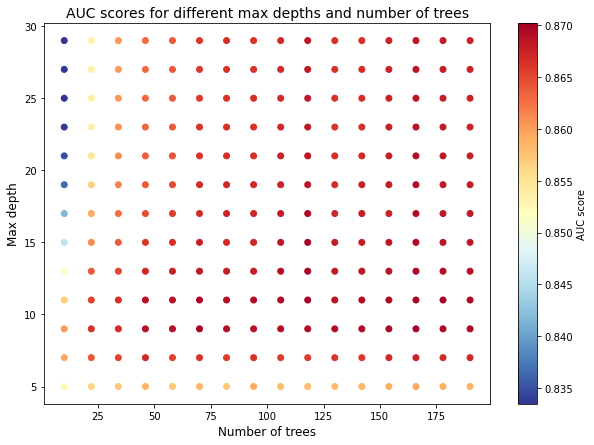

In [37]:
# plot the best number of trees and number of depths
plt.figure(figsize=(10,7))
cm = plt.cm.get_cmap('RdYlBu').reversed()
sc = plt.scatter(numTrees, maxDepths, c = AUCs, cmap=cm)
plt.colorbar(sc, label='AUC score')
plt.title('AUC scores for different max depths and number of trees', fontsize=14)
plt.xlabel('Number of trees', fontsize=12)
plt.ylabel('Max depth', fontsize=12)
plt.savefig('AUCscores_final')
plt.show()

### Load model

In [46]:
# Load
from pyspark.ml.classification import RandomForestClassificationModel
rfModel = RandomForestClassificationModel.load("/data/shared1/cleandata/rf_model_optimal_thresholds.model")

In [34]:
# print model
print(rfModel.toDebugString)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



### Feature importance

In [47]:
# find feature importances as percent
importances = rfModel.featureImportances
importances = [imp * 100 for imp in importances]
feature_importances = list(zip(importances, selected_features))
feature_importances.sort()

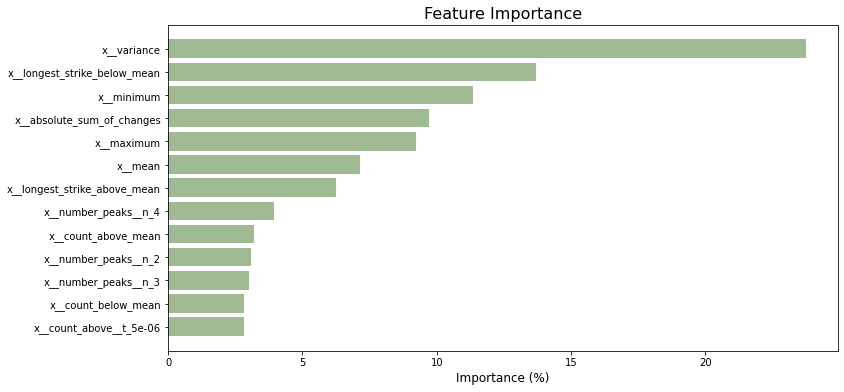

In [48]:
plt.figure(figsize=(12,6))
plt.barh([imp[1] for imp in feature_importances], [imp[0] for imp in feature_importances], color = '#A0BB94')
plt.title('Feature Importance',fontsize=16)
plt.xlabel('Importance (%)',fontsize=12)
#plt.savefig('feature_importance_final',bbox_inches='tight')
plt.show()

### Confusion matrix

In [29]:
preds_and_labels = predictions.select(['prediction','label']).withColumn('label', F.col('label').cast(FloatType())).orderBy('prediction')

preds_and_labels = preds_and_labels.select(['prediction','label'])

metrics = MulticlassMetrics(preds_and_labels.rdd.map(tuple))

print(metrics.confusionMatrix().toArray())

[[56292. 17940.]
 [ 5797. 14343.]]


In [30]:
cf_matrix = metrics.confusionMatrix().toArray()

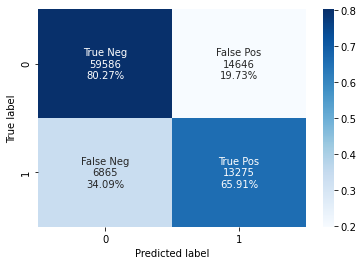

In [36]:
# binary
group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
group_percentages = [cf_matrix[i]/np.sum(cf_matrix[i]) for i in range(0,2)]
group_percentages = np.asarray(group_percentages)
group_percentages_label = ["{0:.2%}".format(value) for value in group_percentages.flatten()]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages_label)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(group_percentages, annot=labels, fmt='', cmap='Blues')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.savefig('confusion_final')
plt.show()

### Statistics

In [37]:
#Overall statistics
precision = metrics.precision()
recall = metrics.recall()
f1Score = metrics.fMeasure()
print("Summary Stats")
print("Precision = %s" % precision)
print("Recall = %s" % recall)
print("F1 Score = %s" % f1Score)

TypeError: precision() missing 1 required positional argument: 'label'

### ROC plot (binary only)

In [41]:
# Scala version implements .roc() and .pr()
# Python: https://spark.apache.org/docs/latest/api/python/_modules/pyspark/mllib/common.html
# Scala: https://spark.apache.org/docs/latest/api/java/org/apache/spark/mllib/evaluation/BinaryClassificationMetrics.html
class CurveMetrics(BinaryClassificationMetrics):
    def __init__(self, *args):
        super(CurveMetrics, self).__init__(*args)

    def _to_list(self, rdd):
        points = []
        # Note this collect could be inefficient for large datasets 
        # considering there may be one probability per datapoint (at most)
        # The Scala version takes a numBins parameter, 
        # but it doesn't seem possible to pass this from Python to Java
        for row in rdd.collect():
            # Results are returned as type scala.Tuple2, 
            # which doesn't appear to have a py4j mapping
            points += [(float(row._1()), float(row._2()))]
        return points

    def get_curve(self, method):
        rdd = getattr(self._java_model, method)().toJavaRDD()
        return self._to_list(rdd)

In [42]:
# Returns as a list (false positive rate, true positive rate)
preds = predictions.select('label','probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['label'])))
points = CurveMetrics(preds).get_curve('roc')

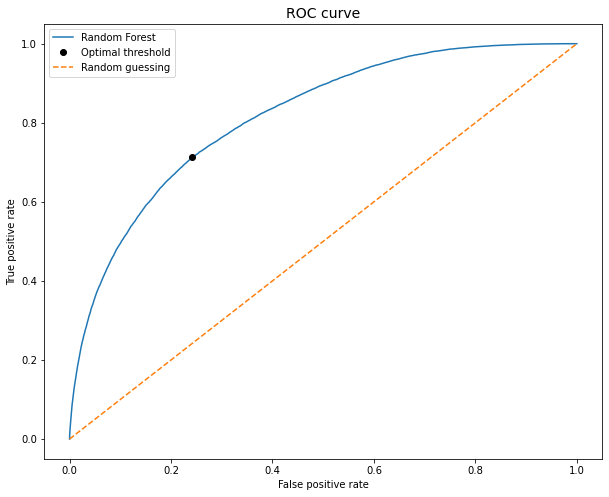

In [43]:
plt.figure(figsize=(10,8))
x_val = [x[0] for x in points]
y_val = [x[1] for x in points]
plt.title("ROC curve", fontsize=14)
plt.xlabel("False positive rate", fontsize=10)
plt.ylabel("True positive rate", fontsize=10)
plt.plot(x_val, y_val, label='Random Forest')
plt.plot(fpr[ix], tpr[ix], 'ok', label='Optimal threshold')
plt.plot([0,1], [0,1], '--', label='Random guessing')
plt.legend()
plt.savefig('ROC_new')
plt.show()

### Find best threshold (binary only)

In [35]:
from sklearn import metrics

In [36]:
y = np.array(predictions.select('label').collect())
scores = np.array(predictions.select('probability').collect())

In [37]:
ynew = y.reshape(-1)
scorenew = np.zeros((len(scores)))

for i in range(0, len(scores)):
    scorenew[i] = scores[i][0][1]

In [38]:
fpr, tpr, thresholds = metrics.roc_curve(ynew, scorenew)

In [39]:
metrics.roc_auc_score(ynew, scorenew)

0.8163745302041866

In [40]:
J = tpr - fpr
ix = argmax(J)
best_thresh = thresholds[ix]
print('Best Threshold=%f' % (best_thresh))

Best Threshold=0.457799
